In [133]:
import os

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy as gp
from notebooks.tasks58.plots import plot_correlations, all_negative, all_positive
from notebooks.tasks58.scaling import median_scaling

import os

while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [22]:
import os

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy as gp
from notebooks.tasks58.plots import plot_correlations, all_negative, all_positive
from notebooks.tasks58.scaling import median_scaling

import os

while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [23]:
def parse_bg_signatures():
    file = open('raw/bg_gene_signatures.gmt', 'r')
    res = dict()
    for line in file.readlines():
        lst = line.split('\t')
        res['SIGNATURE_' + lst[0]] = lst[2:]
    return res

def compute_ssgsea_on_signatures(log_tpm, signatures):
    ssgsea_results = gp.ssgsea(data=log_tpm.T,
                           gene_sets=signatures,
                           outdir=None,
                           sample_norm_method='rank',
                           permutation_num=0,
                           no_plot=True,
                           min_size=0)

    ssgsea_df = ssgsea_results.res2d.rename(columns={'Name': 'sample_id'})
    
    log_tpm_with_signatures = log_tpm.copy()
    
    for signature in signatures:
        add = ssgsea_df.loc[ssgsea_df['Term'] == signature, ['sample_id', 'ES']]
        log_tpm_with_signatures = log_tpm_with_signatures.merge(add, left_index=True,
                                                                          right_on='sample_id').rename(
            columns={'ES': signature}).set_index('sample_id').astype({signature: np.float64})
    
    # Scale separetely
    for i, signature in enumerate(signatures):
        log_tpm_with_signatures[signature + '_med'] = median_scaling(log_tpm_with_signatures[signature])

    return log_tpm_with_signatures


In [24]:
signatures = parse_bg_signatures()

log_tpm_1 = pd.read_csv('data/log_tpms_from_fpkm_hgnc_filtered_by_ann.csv', index_col=0)
ann_1 = pd.read_csv('data/ann.csv', index_col=0)
df_1 = compute_ssgsea_on_signatures(log_tpm_1, signatures)

log_tpm_2 = pd.read_csv('raw/exprs_PRJNA805525.csv', index_col=0)
ann_2 = pd.read_csv('raw/ann_PRJNA805525.csv', index_col=0)
df_2 = compute_ssgsea_on_signatures(log_tpm_2, signatures)

/tmp/ipykernel_6652/2614795433.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_tpm_with_signatures[signature + '_med'] = median_scaling(log_tpm_with_signatures[signature])
/tmp/ipykernel_6652/2614795433.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_tpm_with_signatures[signature + '_med'] = median_scaling(log_tpm_with_signatures[signature])
/tmp/ipykernel_6652/2614795433.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [158]:
df_all = pd.concat([df_1[[col for col in df_1.columns if col.endswith('_med')]],
                    df_2[[col for col in df_2.columns if col.endswith('_med')]]])
df_all.index

Index(['18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002',
       '18R674_0006', '18R678_0010', '18R683_0015', '18R694_0002',
       '18R699_0007', '18R700_0008',
       ...
       'GSM5890091', 'GSM5890104', 'GSM5890115', 'GSM5890157', 'GSM5890183',
       'GSM5890186', 'GSM5890205', 'GSM5890210', 'GSM5890228', 'GSM5890257'],
      dtype='object', name='sample_id', length=199)

In [159]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

In [160]:
if 'SIGNATURE_' in df_all.columns[0]:
    df_all = df_all.rename(columns={col: col[len('SIGNATURE_'):-len('_med')] for col in df_all.columns})

[0.38594458 0.14282517]


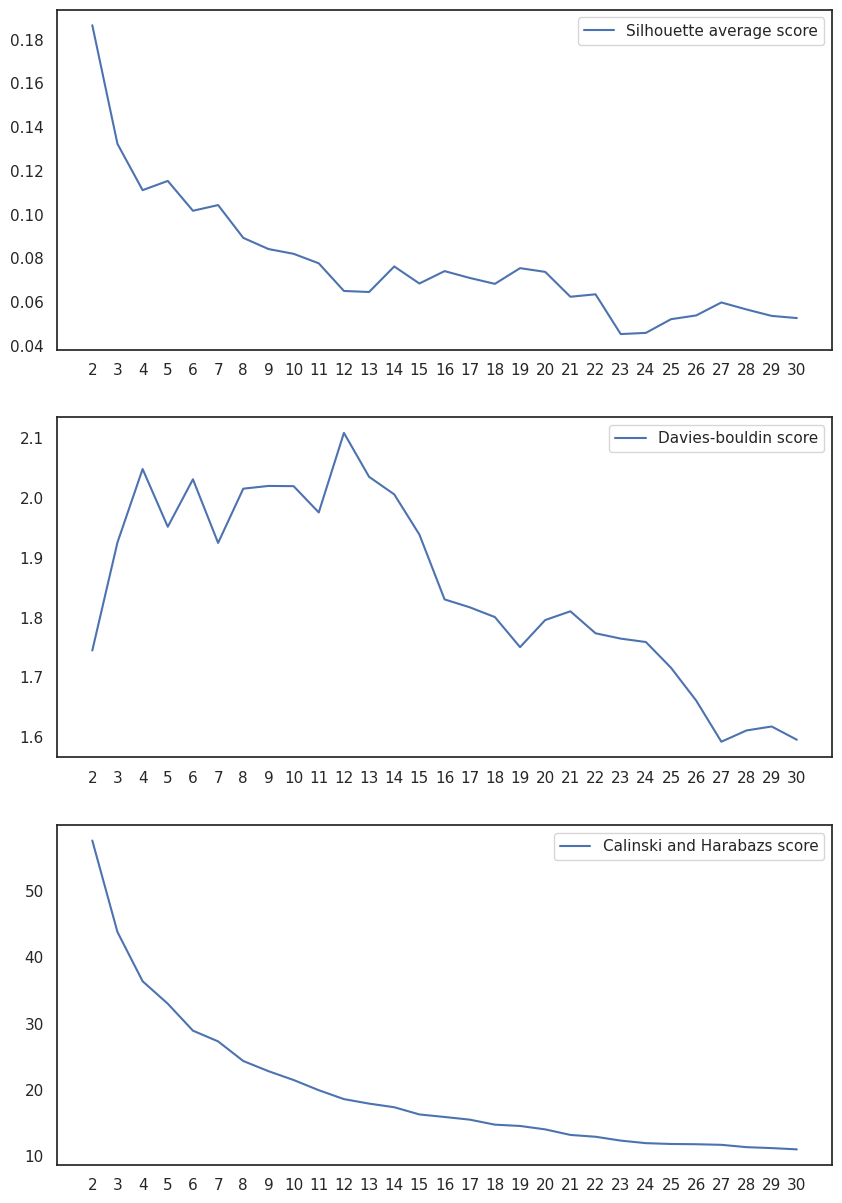

In [161]:
pca = PCA(n_components=2)
df_all_2d = pca.fit_transform(df_all)
print(pca.explained_variance_ratio_)

N_clusters_max = 30

n_clus = []
sa_scores = []
db_scores = []
ch_scores = []

labels = []

# fig, axs = plt.subplots(20, 1, figsize=(8, 20*8))
for n_clusters in np.arange(2, N_clusters_max + 1):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_all)
    labels.append(cluster_labels)
    
    sa_score = silhouette_score(df_all, cluster_labels)
    db_score = davies_bouldin_score(df_all, cluster_labels)
    ch_score = calinski_harabasz_score(df_all, cluster_labels)
    
    n_clus.append(n_clusters)
    sa_scores.append(sa_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)
    
    # axs[n_clusters - 2].scatter(df_all_2d[:,0], df_all_2d[:,1], c=cluster_labels)

fig, axs = plt.subplots(3, 1, figsize=(N_clusters_max // 3, 3 * 5))
axs[0].plot(n_clus, sa_scores, label='Silhouette average score')
axs[1].plot(n_clus, db_scores, label='Davies-bouldin score')
axs[2].plot(n_clus, ch_scores, label='Calinski and Harabazs score')

for i in range(3):
    axs[i].legend()
    axs[i].set_xticks(np.arange(2, N_clusters_max + 1))
# 
# print(sa_scores)
# print(db_scores)
# print(ch_scores)

<Figure size 1600x1600 with 0 Axes>

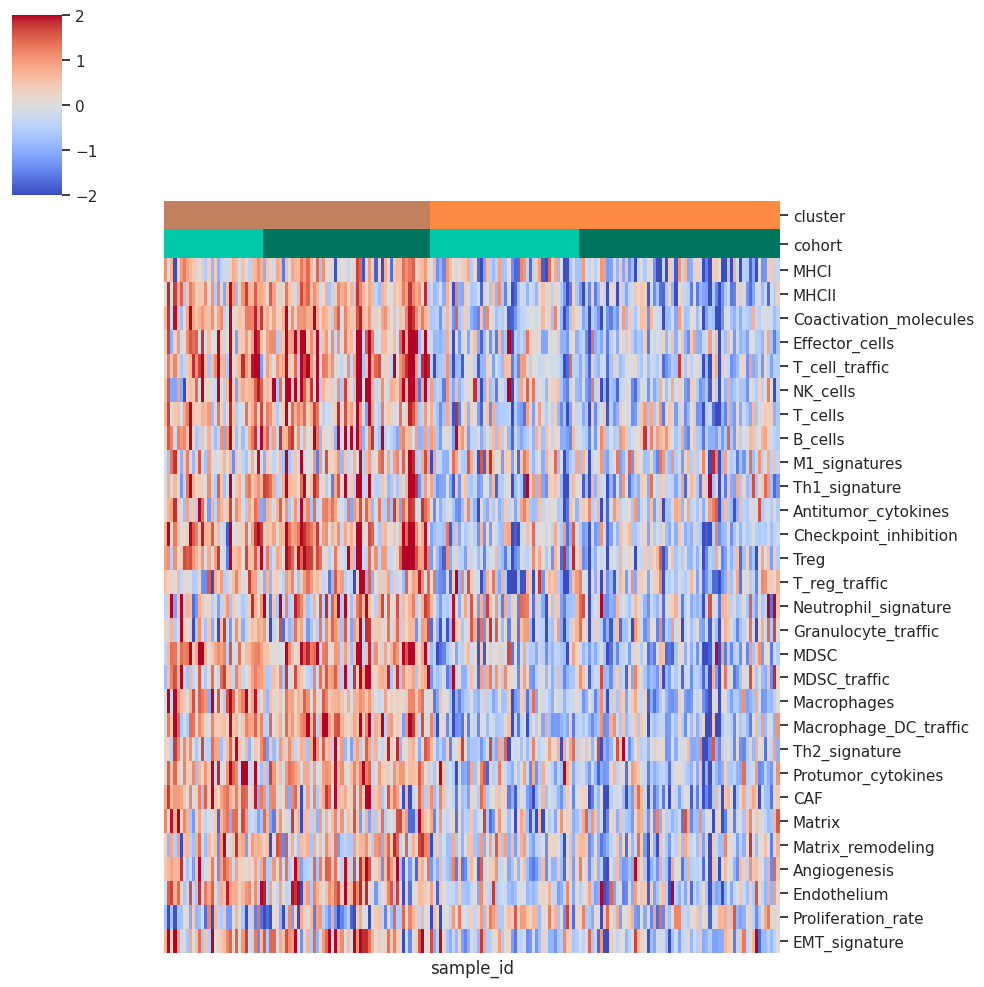

<Figure size 1600x1600 with 0 Axes>

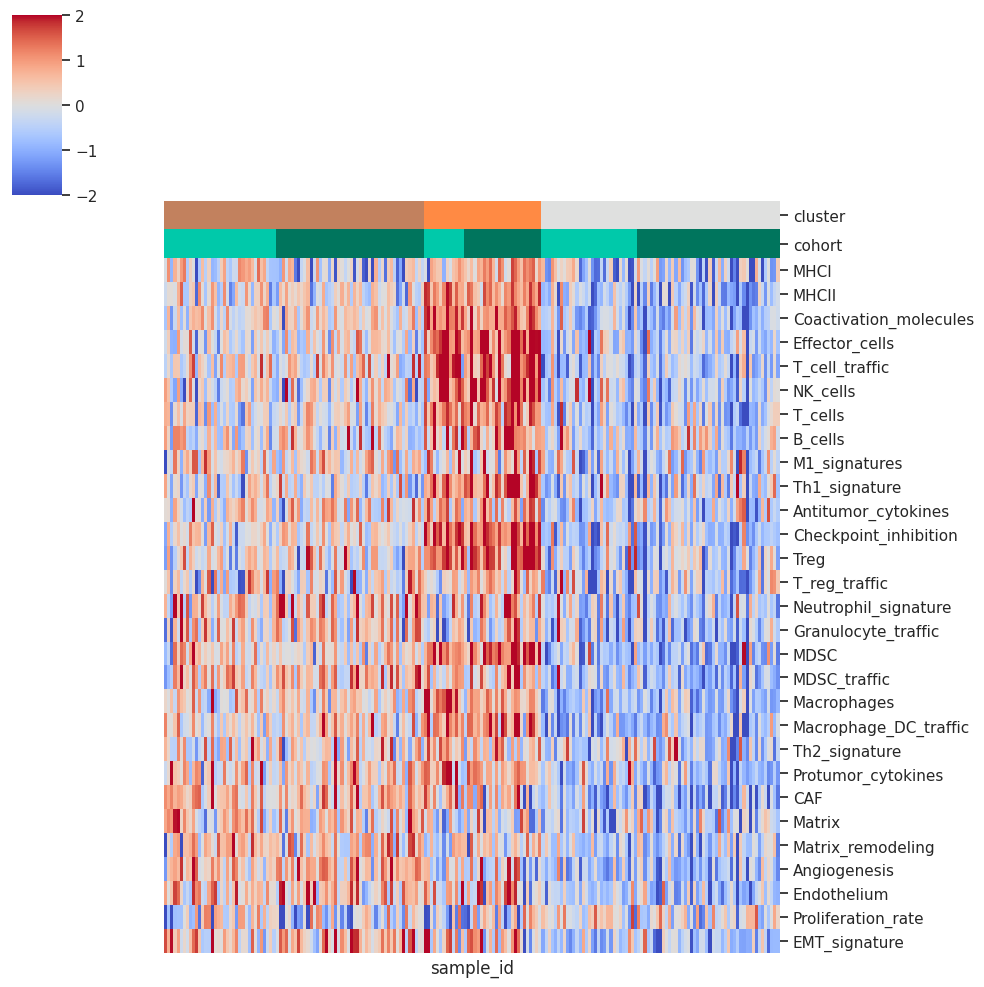

<Figure size 1600x1600 with 0 Axes>

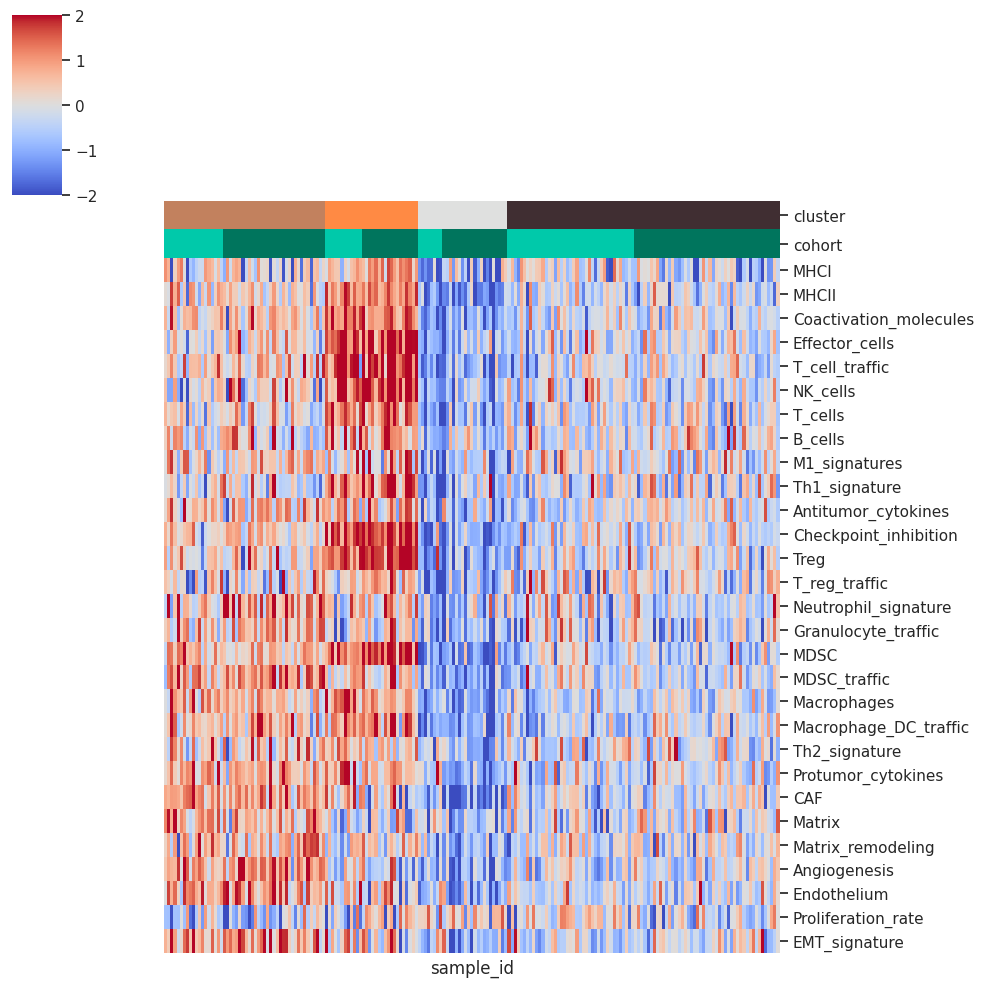

In [184]:
import matplotlib 

def label_to_color(label):
    if label == 0:
        return '#c2815e'
    elif label == 1:
        return '#ff8a44'
    elif label == 2:
        return '#dfe0df'
    elif label == 3:
        return '#402e32'
    elif label == -1:
        return '#00755d'
    elif label == -2:
        return '#00c9aa'
    else:
        print('Label', label, type(label))
        raise Exception('invalid label')

def get_cohort_id(s):
    if s.startswith('GSM'):
        return -1
    else:
        return -2

def plot_heatmap(clbs):
    cohort_ids = pd.Series([get_cohort_id(e) for e in df_all.index], dtype=int, index=df_all.index) 
    
    sorted_labels_idx = np.lexsort((cohort_ids, clbs))
    sorted_labels = pd.Series(clbs, dtype=int, name='labels', index=df_all.index).iloc[sorted_labels_idx]
    sorted_df_all = df_all.loc[sorted_labels.index]
    sorted_cohort_ids = cohort_ids[sorted_labels.index]
    
    plt.figure(figsize=(16, 16))
    sns.set(style='white', rc={'figure.figsize': (20, 20)}, font_scale=1)
    
    cohort_colors = pd.DataFrame({'cluster': sorted_labels, 'cohort': sorted_cohort_ids}).map(label_to_color)
    
    g = sns.clustermap(sorted_df_all.T, 
                        vmin=-2.0, vmax=2.0,
                        cmap=matplotlib.cm.coolwarm,
                        col_colors=cohort_colors,
                        col_cluster=False,
                        row_cluster=False,
                        xticklabels=False)
    
    
    plt.show()

plot_heatmap(labels[0])
plot_heatmap(labels[1])
plot_heatmap(labels[2])